# TensorFlow Structure Column Data Tutorial

In [1]:
!pip install sklearn

import pathlib

import numpy as np
import pandas as pd

import tensorflow as tf

from tensorflow import feature_column
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

In [2]:
# Use pandas to load the Pet CSV DataSet
url = 'http://storage.googleapis.com/download.tensorflow.org/data/petfinder-mini.zip'
csv = './data/datasets/petfinder-mini/petfinder-mini.csv'

tf.keras.utils.get_file('petfinder_mini.zip', url, extract=True, cache_dir='./data')

df = pd.read_csv(csv)

In [3]:
# We can see that we have lots of categorical columns (Breed/Gender etc), some numerical columns (fee/age)
# and some useless test columns (Description).
# The labels we are trying to predict are the Adoption Speed
# TUTORIAL WANTS TO CONVERT TO BINARY CLASSIFICATION BUT GOING TO KEEP IT AS MULTI FOR A CHALLENGE
df.head(5)

,Type,Age,Breed1,Gender,Color1,Color2,MaturitySize,FurLength,Vaccinated,Sterilized,Health,Fee,Description,PhotoAmt,AdoptionSpeed
0,Cat,3,Tabby,Male,Black,White,Small,Short,No,No,Healthy,100,Nibble is a 3+ month old ball of cuteness. He ...,1,2
1,Cat,1,Domestic Medium Hair,Male,Black,Brown,Medium,Medium,Not Sure,Not Sure,Healthy,0,I just found it alone yesterday near my apartm...,2,0
2,Dog,1,Mixed Breed,Male,Brown,White,Medium,Medium,Yes,No,Healthy,0,Their pregnant mother was dumped by her irresp...,7,3
3,Dog,4,Mixed Breed,Female,Black,Brown,Medium,Short,Yes,No,Healthy,150,"Good guard dog, very alert, active, obedience ...",8,2
4,Dog,1,Mixed Breed,Male,Black,No Color,Medium,Short,No,No,Healthy,0,This handsome yet cute boy is up for adoption....,3,2


In [4]:
# Drop unneeded columns
df = df.drop('Description', axis=1)
df['AdoptionSpeed'] = np.where(df['AdoptionSpeed']==4, 0, 1)

In [5]:
# Split the Dataset
train, test = train_test_split(df, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)
print(f'train: {len(train)} \nval: {len(val)} \ntest: {len(test)}')

train: 7383 
val: 1846 
test: 2308


In [6]:
# Input pipeline --> Convert DF to tf.data batches
def df_to_dataset(df, shuffle=True, batch_size=32):
    df = df.copy()
    labels = df.pop('AdoptionSpeed') # Pop labels from dataframe
    ds = tf.data.Dataset.from_tensor_slices((dict(df), labels)) # Supply a (features, labels) tuple to dataset
    if shuffle:
        ds = ds.shuffle(buffer_size=len(df))
    ds = ds.batch(batch_size)
    return ds

train_ds = df_to_dataset(train)
val_ds = df_to_dataset(val, shuffle=False)
test_ds = df_to_dataset(test, shuffle=False)

In [7]:
# Test input pipeline
for feature_b, label_b in train_ds.take(1):
    print(f'Feature Keys: {list(feature_b.keys())}')
    print(f'Ages: {feature_b["Age"]}')
    print(f'Adoption Speeds: {label_b}')

Feature Keys: ['Type', 'Age', 'Breed1', 'Gender', 'Color1', 'Color2', 'MaturitySize', 'FurLength', 'Vaccinated', 'Sterilized', 'Health', 'Fee', 'PhotoAmt']
Ages: [36 72  6  2  2  5 22  1  2  3  3  2 72  2 14  2  4 24  2  1  4  1  1  1
  2  2  3  8  9  3  5  2]
Adoption Speeds: [1 1 0 1 1 0 1 1 1 1 1 1 0 1 0 1 1 0 1 1 1 1 0 1 1 1 1 1 0 0 0 1]


### Generate Different Feature Column Types

In [8]:
example_batch = next(iter(train_ds))[0] # Extract a single batch
def test_ft(ft_col): # Test function to demonstrate how the different feature columns transform the data
    ft_layer = layers.DenseFeatures(ft_col)
    print(ft_layer(example_batch).numpy())

In [9]:
# the output of a feature columns becomes the input to the model, our test_ft function will show what each tranform does
# The simplest is NUMERIC. This leaves real valued features unchanged, as shown below
photo_count = feature_column.numeric_column('PhotoAmt')
test_ft(photo_count)

[[3.]
 [3.]
 [2.]
 [2.]
 [5.]
 [4.]
 [5.]
 [2.]
 [3.]
 [1.]
 [2.]
 [1.]
 [3.]
 [3.]
 [4.]
 [2.]
 [0.]
 [2.]
 [3.]
 [3.]
 [7.]
 [0.]
 [4.]
 [1.]
 [9.]
 [3.]
 [4.]
 [2.]
 [5.]
 [2.]
 [4.]
 [5.]]


In [10]:
# We can change continous values into bucketized one-hot columns: Example usage would be age ranges
age = feature_column.numeric_column('Age')
age_buckets = feature_column.bucketized_column(age, boundaries=[1,3,5])
test_ft(age_buckets)

[[0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]]


In [11]:
# In this dataset must columns are Categorical. So we need different ways to represent them
# We can convert string categorical columns to one-hot encoding using categorical_column_with_vocabulary_list() 
# Which does what its name says
animal_type = feature_column.categorical_column_with_vocabulary_list('Type', ['Cat', 'Dog']) # Intermediat step
animal_type_o_h = feature_column.indicator_column(animal_type) # Must wrap with idicator
test_ft(animal_type_o_h)

[[0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [12]:
# Embedding Columns: In datasets where we have huge numbers of categories it becomes infeasible to train with 
# One-Hot encoding because the dataset will be too large.
# We cab use embedding where we represent the one-hot vector as a dense lower dimensional vector where the values
# are not limited to binary. 
# The embedding size is a hyperparameter worth tuning
breed1 = feature_column.categorical_column_with_vocabulary_list('Breed1', df.Breed1.unique())
breed1_embedding = feature_column.embedding_column(breed1, dimension=8)
test_ft(breed1_embedding)

[[-0.27472916  0.3568715  -0.50055313 -0.20244935  0.11585673  0.23010774
   0.543198   -0.27869853]
 [-0.5657737   0.12406021 -0.1850852   0.01447107 -0.5924709  -0.5643914
  -0.24445656  0.65408033]
 [ 0.12071966  0.14090234 -0.5428226  -0.29859468 -0.39763734  0.23409088
   0.03504107  0.19074157]
 [-0.5657737   0.12406021 -0.1850852   0.01447107 -0.5924709  -0.5643914
  -0.24445656  0.65408033]
 [-0.43171206  0.07397582  0.33168063  0.16122533  0.01508192  0.35938072
  -0.10099246 -0.08821006]
 [-0.43171206  0.07397582  0.33168063  0.16122533  0.01508192  0.35938072
  -0.10099246 -0.08821006]
 [-0.5657737   0.12406021 -0.1850852   0.01447107 -0.5924709  -0.5643914
  -0.24445656  0.65408033]
 [-0.5657737   0.12406021 -0.1850852   0.01447107 -0.5924709  -0.5643914
  -0.24445656  0.65408033]
 [-0.5657737   0.12406021 -0.1850852   0.01447107 -0.5924709  -0.5643914
  -0.24445656  0.65408033]
 [-0.43171206  0.07397582  0.33168063  0.16122533  0.01508192  0.35938072
  -0.10099246 -0.08821

In [13]:
# Another way to represent catergoricals with lots of values is to use a hashed feature column
# The feature column calculates a hash value for the input and then encodes the string into a bucket of a given size
# This is good because you dont need the vocabulary and you can make the bucket_size much smaller than the number of categories
breed1_hash = feature_column.categorical_column_with_hash_bucket('Breed1', hash_bucket_size=10)
breed1_hash_ind = feature_column.indicator_column(breed1_hash)
test_ft(breed1_hash_ind)

[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0.

In [14]:
# Crossed feature columns: By combining columns you can train the model on all the different data intersections
# Allowing it to learn about the correlations between features more
crossed_ft = feature_column.crossed_column([age_buckets, animal_type], hash_bucket_size=10)
crossed_ft_ind = feature_column.indicator_column(crossed_ft)
test_ft(crossed_ft_ind)

[[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0.

## Chose which Feature Columns to use and In what type

In [15]:
# In reality we should think abouyt which features are/aren't important and use a larger dataset
feature_cols = []

# Numeric
for header in ['PhotoAmt', 'Fee', 'Age']:
    feature_cols.append(feature_column.numeric_column(header))

# Bucketised Cols
age = feature_column.numeric_column('Age')
age_buckets = feature_column.bucketized_column(age, boundaries=[1,2,3,4,5])
feature_cols.append(age_buckets)

# Indicator Cols
indicator_cols = ['Type', 'Color1', 'Color2', 'Gender', 'MaturitySize', 
                  'FurLength', 'Vaccinated', 'Sterilized', 'Health']

for col in indicator_cols:
    cat_col = feature_column.categorical_column_with_vocabulary_list(col, df[col].unique())
    ind_col = feature_column.indicator_column(cat_col)
    feature_cols.append(ind_col)
    
# Embedding Cols
breed1 = feature_column.categorical_column_with_vocabulary_list('Breed1', df.Breed1.unique())
breed1_embedding = feature_column.embedding_column(breed1, dimension=8)
feature_cols.append(breed1_embedding)

# Crossed Cols
animal_type = feature_column.categorical_column_with_vocabulary_list('Type', ['Cat', 'Dog'])
age_type = feature_column.crossed_column([age_buckets, animal_type], hash_bucket_size=100)
age_type_crossed = feature_column.indicator_column(age_type)
feature_cols.append(age_type_crossed)

In [20]:
num_outputs = len(df['AdoptionSpeed'].unique())
num_outputs

2

In [29]:
# Now we have defined features, use a densefeatures layer to input them to the model
feature_layer = tf.keras.layers.DenseFeatures(feature_cols)
reg = 0.001
do = 0.2
epochs = 100

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling

def get_callbacks():
    return [
        tfdocs.modeling.EpochDots(), # <= prints full logs every 100 epochs and . for the rest
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15)]

model = tf.keras.Sequential([
    feature_layer,
    layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg)),
    layers.Dropout(do),
    layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg)),
    layers.Dropout(do),
    layers.Dense(num_outputs - 1)  
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_ds,
          validation_data=val_ds,
          epochs=epochs,
          callbacks=get_callbacks())

Epoch 1/100
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
225/231 [============================>.] - ETA: 0s - loss: 0.8692 - accuracy: 0.6781WARNING:tensorflow:Layers in a Sequential model should only have a single input tensor, but we receive a <class 'dict'> input: {'Type': <tf.Tensor 'ExpandDims_11:0' shape=(None, 1) dtype=string>, 'Age': <tf.Tensor 'ExpandDims:0' shape=(None, 1) dtype=int64>, 'Breed1': <tf.Tensor 'ExpandDims_1:0' shape=(None, 1) dtype=string>, 'Gender': <tf.Tensor 'ExpandDims_6:0' shape=(None, 1) dtype=string>, 'Color1': <tf.Tensor 'ExpandDims_2:0' shape=(None, 1) dtype=string>, 'Color2': <tf.Tensor 'ExpandDims_3:0' shape=(None, 1) dtype=string>, 'MaturitySize': <tf.Tensor 'ExpandDims_8:0' shape=(None, 1) dtype=string>, 'FurLength': <tf.Tensor 'ExpandDims_5:0' shape=(None, 1) dtype=string>, 'Vaccinated': <tf.Tensor 'ExpandDims_12:0' shape=(None, 1) dtype=string>, 'Sterilized': <tf.Tensor 'ExpandDims_1

231/231 [==============================] - 0s 2ms/step - loss: 0.4909 - accuracy: 0.7532 - val_loss: 0.5249 - val_accuracy: 0.7248
Epoch 35/100
231/231 [==============================] - 0s 2ms/step - loss: 0.4906 - accuracy: 0.7550 - val_loss: 0.5314 - val_accuracy: 0.7438
Epoch 36/100
231/231 [==============================] - 0s 2ms/step - loss: 0.4885 - accuracy: 0.7586 - val_loss: 0.5194 - val_accuracy: 0.7432
Epoch 37/100
231/231 [==============================] - 0s 2ms/step - loss: 0.4864 - accuracy: 0.7599 - val_loss: 0.5260 - val_accuracy: 0.7113
Epoch 38/100
231/231 [==============================] - 0s 2ms/step - loss: 0.4860 - accuracy: 0.7552 - val_loss: 0.5215 - val_accuracy: 0.7411
Epoch 39/100
231/231 [==============================] - 0s 2ms/step - loss: 0.4845 - accuracy: 0.7584 - val_loss: 0.5180 - val_accuracy: 0.7432
Epoch 40/100
231/231 [==============================] - 0s 2ms/step - loss: 0.4867 - accuracy: 0.7573 - val_loss: 0.5228 - val_accuracy: 0.7416
Epoch

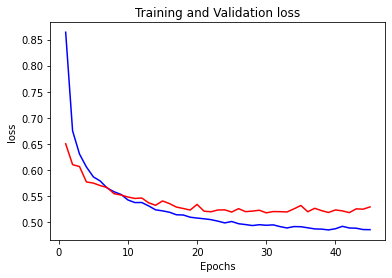

In [30]:
from matplotlib import pyplot as plt
def plot_metrics(history, metric):
    met = history[metric]
    val_metric = history[('val_' + metric)]
    epochs = range(1, len(met) + 1)
    
    plt.plot(epochs, met, 'b', label=('Training ' + metric))
    plt.plot(epochs, val_metric, 'r', label=('Validation ' + metric))
    plt.title('Training and Validation ' + metric)
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.show()

plot_metrics(history.history, 'loss')    

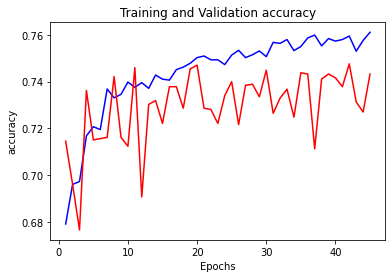

In [31]:
plot_metrics(history.history, 'accuracy')

In [32]:
loss, accuracy = model.evaluate(test_ds)
print("Accuracy", accuracy)

73/73 [==============================] - 0s 1ms/step - loss: 0.5368 - accuracy: 0.7379
Accuracy 0.7378683090209961


This model is inaccurate and performs poorly due to the fact it is a small dataset with not many features, it woul dbe better to use a decision tree or random forrest for something like this.